
<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Practice Session - 09  </font></center></h1>
<h2><center> <font color='black'> Hate Speech</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


# Already Covered:
1. **Get familiar with the graphs and how to work with them using igraph library; [Lab - 02]**
2. **Analyse the data about media companies. Figure out their connections; [Lab - 02]**
3. **Learn about various way of displaying statistic on the graphs; [Lab - 02]**
4. **Network models and descriptions using Networkx library; [Lab - 03]**

5. **Network Centrality Measures using networkx; [Lab - 04]**
6. **Network Communities using networkx/igraph [Lab - 05]**
7. **Link Prediction [Lab - 06]**
8. **Graph Based Text Representation [Lab - 07]**
9. **Echo Chambers and Polarization [Lab - 08]**

# Today's session agenda:
+ **Hate Speech**
  1. Identification <br>
    1.1. Using two different transformer models to identify hatespeech <br>
    1.2. Calculate Inter-Annotator agreement scores <br>
    1.3. Use voting for final labels
  2. Reddit users and their toxic content Author Networks <br>
    2.1. BERT Embeddings of text <br>
    2.2. Toxic Authors Network <br>

## Loading and installing all required packages

In [ ]:
!pip install krippendorff

In [ ]:
import re
import krippendorff
import nltk

import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from networkx import Graph
from transformers import pipeline, BertModel, BertTokenizer
from sklearn.metrics import cohen_kappa_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# 1. Identification

## Load Data



> Davidson, Thomas, et al. "Automated hate speech detection and the problem of offensive language." Proceedings of the international AAAI conference on web and social media. Vol. 11. No. 1. 2017.

Let's load a popular benchmark hate speech dataset to get to know about computing inter-annotator agreement scores


In [ ]:
davidson_data = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")
davidson_data.shape

(24783, 7)

What does the dataset even contain?

In [ ]:
davidson_data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [ ]:
davidson_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We will select columns what we need and ignore the rest

In [ ]:
data = davidson_data[['tweet', 'class']]
data.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [ ]:
data['class'].unique()

array([2, 1, 0])

Why do we have 3 classes? Lets's see...

> Class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

We will make them binary labels for the sake of simplicity



In [ ]:
def combine_class(c):
    if c in [0, 1]:
        return 1
    return 0

In [ ]:
data['class'] = data['class'].apply(combine_class)
data['class'].unique()

<ipython-input-9-5e38a7ac8055>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].apply(combine_class)


array([0, 1])

In [ ]:
data.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


I'm sure 24783 datapoints is a overkill for learning about inter-annotator agreement scores. So I'm sampling 2000 points

In [ ]:
data = data.sample(n=2000, random_state=108)

The thing with social media data is that they usually contain a lot of unwanted elements in the data. Since we are going to use a transformer based model for annotating, let's not worry about it since the tokenizer will take care of it. However, we need to consider handling the URLs.

In [ ]:
def clean_tweet(text):
  # Replace URLs with placeholder
  text = re.sub(r"http\S+", "[URL]", text)

  # Remove extra whitespaces
  text = re.sub(r"\s+", " ", text).strip()

  return text

In [ ]:
data['cleaned'] = data['tweet'].apply(clean_tweet)

## Annotator 1

We don't really have the resources to hire annotators to do the annotation for us, so let's get a transformer model to do it for us. This we also get to use an off-the-shelf hate detection tool. We will use a very good hate speech detection model relased by the CardiffNLP Group.

> cardiffnlp/twitter-roberta-base-hate


In [ ]:
classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-hate", device=-1)
#classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-hate", device=0)

# Make predictions
predictions = classifier(data['cleaned'].tolist())

# Add predictions to the dataframe
data['cardiff'] = [pred['label'] for pred in predictions]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
data.cardiff.unique()

array(['non-hate', 'hate'], dtype=object)

Let's standardise the prediction labels to numbers instead of characters.

In [ ]:
def change_class(c):
    if c == 'non-hate':
        return 0
    return 1

data['cardiff'] = data['cardiff'].apply(change_class)

In [ ]:
data.head()

,tweet,class,cleaned,cardiff
21133,Spring breakkkk bitches &#128513;,1,Spring breakkkk bitches &#128513;,0
538,"""On top of that, she just a pregnant ass sorry...",1,"""On top of that, she just a pregnant ass sorry...",1
22122,This niggah seems really clingy... Mhmm idk ab...,1,This niggah seems really clingy... Mhmm idk ab...,0
15553,"RT @IAMNICKlMINAJ: I'm not saying she's a hoe,...",1,"RT @IAMNICKlMINAJ: I'm not saying she's a hoe,...",1
7776,Another long mornin smh...Thank God a nicca ou...,1,Another long mornin smh...Thank God a nicca ou...,0


## Annotator 2

 For annotator, let's use a different model. This time Meta's model/



> facebook/roberta-hate-speech-dynabench-r4-target



> Bertie Vidgen, Tristan Thrush, Zeerak Waseem, and Douwe Kiela. 2021. Learning from the Worst: Dynamically Generated Datasets to Improve Online Hate Detection. In Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers), pages 1667–1682, Online. Association for Computational Linguistics.



In [ ]:
classifier = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target", device=-1)
#classifier = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target", device=0)

# Make predictions
predictions = classifier(data['cleaned'].tolist())

# Add predictions to the dataframe
data['facebook'] = [pred['label'] for pred in predictions]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
data.facebook.unique()

array(['hate', 'nothate'], dtype=object)

In [ ]:
def change_class(c):
    if c == 'nothate':
        return 0
    return 1

data['facebook'] = data['facebook'].apply(change_class)

In [ ]:
data.head()

,tweet,class,cleaned,cardiff,facebook
21133,Spring breakkkk bitches &#128513;,1,Spring breakkkk bitches &#128513;,0,1
538,"""On top of that, she just a pregnant ass sorry...",1,"""On top of that, she just a pregnant ass sorry...",1,1
22122,This niggah seems really clingy... Mhmm idk ab...,1,This niggah seems really clingy... Mhmm idk ab...,0,1
15553,"RT @IAMNICKlMINAJ: I'm not saying she's a hoe,...",1,"RT @IAMNICKlMINAJ: I'm not saying she's a hoe,...",1,1
7776,Another long mornin smh...Thank God a nicca ou...,1,Another long mornin smh...Thank God a nicca ou...,0,1


## Inter-Annotator Agreement Score

Inter-annotator agreement (IAA) scores are crucial metrics used in various fields, particularly in the context of data annotation and labeling tasks. They quantify the level of agreement or consistency among multiple annotators when assigning labels or annotations to a given dataset. These scores are essential for assessing the reliability and quality of annotated data, especially in fields like natural language processing (NLP), computer vision, and social sciences.

Two commonly used measures for calculating inter-annotator agreement are Krippendorff's alpha and Cohen's Kappa. While both aim to assess the agreement among annotators, they have different properties and are suited for different types of data and contexts.

| **Criteria**                                 | **Cohen's Kappa**                                                              | **Krippendorff's Alpha**                                                                       |
|----------------------------------------------|--------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Types of Data**                            | Primarily suited for categorical data with two or more categories.            | More versatile, can handle various types of data: categorical, ordinal, interval, and ratio. |
| **Handling of Chance Agreement**             | Adjusts for chance agreement explicitly using a chance agreement probability. | Considers chance agreement implicitly by comparing observed agreement against expected.       |
| **Applicability**                            | Commonly used in psychology and linguistics fields.                           | More widely applicable across different disciplines due to its versatility.                   |

In [ ]:
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(data['cardiff'].tolist(), data['facebook'].tolist())
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.28290698476177334


Not good, am I right? Now, think about why the selection of annotators is really important.

In [ ]:
annotations = [data['cardiff'].tolist(),   # Annotator 1
               data['facebook'].tolist(),  # Annotator 2
               data['class'].tolist()]     # Annotator 3

# Calculate Krippendorff's alpha
alpha = krippendorff.alpha(reliability_data=annotations)
print("Krippendorff's Alpha:", alpha)

Krippendorff's Alpha: 0.3325485934814756


Since there are some disagreements for the labels, let us now do majority voting to fix on a final label.

In [ ]:
data['label'] = data["cardiff"] + data["facebook"] + data["class"]
data['label'] = data['label'].apply(lambda x: 1 if x > 1 else 0)

In [ ]:
final_data = data[['tweet', 'label']]
final_data.head()

,tweet,label
21133,Spring breakkkk bitches &#128513;,1
538,"""On top of that, she just a pregnant ass sorry...",1
22122,This niggah seems really clingy... Mhmm idk ab...,1
15553,"RT @IAMNICKlMINAJ: I'm not saying she's a hoe,...",1
7776,Another long mornin smh...Thank God a nicca ou...,1


Wow! Now we can actually use this data to develop models or methods to identify hate speech.

In [ ]:
# TASK: Find data points of disagreement between class and facebook to see disagreed points. Do a word cloud to find the frequent words of the set.

# 2. Networks


> Jana Kurrek, Haji Mohammad Saleem, and Derek Ruths. 2020. Towards a Comprehensive Taxonomy and Large-Scale Annotated Corpus for Online Slur Usage. In Proceedings of the Fourth Workshop on Online Abuse and Harms, pages 138–149, Online. Association for Computational Linguistics.

We will now use a modified version of a publicly available dataset that contains reddit posts along with its authors and also LABELS! Make sure to upload the dataset to the runtime.

In [ ]:
# Load your data
data = pd.read_csv('lab_09_hatespeech.csv')
data.head()

,id,text,author,slur,label
0,t1_dy2gnma,You're going to need an F22 from I think 04-05...,a_dewsh,tranny,0
1,t1_c8qmgpb,"Hey, we aren't that racist! We didn't say nig...",ShakeNBakey,nigger,1
2,t1_cwmcqsy,"Hey Everyone! \n\nShared my album on a 4x4, a...",Twinner3,tranny,0
3,t1_dv16dc9,"i literally don't understand this\n\ni, a tran...",callmecasady,tranny,0
4,t1_dg0ibva,I'm a faggot but I ain't no liar.,SpliffaroniTony,faggot,0


Since this is an example, lets select 200 toxic points to make sure that the graph computation is quick

In [ ]:
data = data[data["label"] == 1].sample(n=200, random_state=108)
#data = pd.concat([data[data["label"] == 1].sample(n=100, random_state=108),
#                  data[data["label"] == 0].sample(n=100, random_state=108)])

We can find similarity of two text entities using many methods, one such method is Cosine similarity of TFIDF vectors. It's generally adviceable to clean text for feature based text models.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
  # Tokenize text into lowercase words
  text = text.lower().split()

  # Remove stop words
  stop_words = stopwords.words('english')
  text = [word for word in text if word not in stop_words]

  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]

  # Lemmatization (reduces words to dictionary form)
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(word) for word in text]

  # Join the preprocessed words back into a string
  preprocessed_text = " ".join(text)
  return preprocessed_text

data['cleaned'] = data['text'].apply(preprocess_text)

# Define a function to calculate similarity between posts
def post_similarity(text1, text2):
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([text1, text2])
  similarity = (vectors * vectors.T).toarray()[0][1]
  return similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


https://projector.tensorflow.org/ is a cool website that helps you understand embeddings and how they are in the vector space.

<iframe
  src="https://projector.tensorflow.org"
  style="width:100%; height:300px;"
></iframe>

In [ ]:
%%html
<iframe src="https://playground.tensorflow.org" width="1200" height="1000"></iframe>

We will use a BERT model get the text embeddings of the post and then compute similarity between pairs of text

In [ ]:
def get_bert_embeddings(texts, model_name='bert-base-uncased', device='cpu'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    model.to(device)

    # Tokenize and encode the texts
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass through the model to get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the embeddings
    embeddings = outputs.last_hidden_state

    # Mean pooling over tokens to get sentence embeddings
    sentence_embeddings = torch.mean(embeddings, dim=1)

    return sentence_embeddings

def embedding_similarity(emb1, emb2):
    return F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

In [ ]:
embeddings = get_bert_embeddings(data["text"].tolist())
#embeddings = get_bert_embeddings(data["text"].tolist(), device="cuda")

id_embeddings = {}
for i in range(data.shape[0]):
    id_embeddings[data.iloc[i].id] = embeddings[i]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Finally, we reach the graph part. We will set the nodes as authors and the edges will be if authors made a similar post.

In [ ]:
# Create a network object
G = Graph()

# Add authors as nodes
authors = list(data["author"].unique())
G.add_nodes_from(authors)

Now, let's establish an edge between authors if there is they made posts with similar meaning. We will utilize bert embeddings but you can alter the code to use TFIDF as well. The choice is yours.

In [ ]:
# Iterate through each post
# Takes around ~8 mins to run for the entire dataset or ~2 mins for 400 datapoints

for index, row in data.iterrows():
  # Get the author and text for the current post
  author1 = row["author"]
  #text1 = row["cleaned"]
  text1_id = row["id"]

  # Compare similarity with all other posts
  for author2 in authors:
    if author1 != author2:
      #text2 = data[data["author"] == author2]["cleaned"].iloc[0]
      #similarity = post_similarity(text1, text2)

      text2_id = data[data["author"] == author2]["id"].iloc[0]
      similarity = embedding_similarity(id_embeddings[text1_id], id_embeddings[text2_id])

      # Add an edge if similarity is above a threshold
      if similarity > 0.9:  # You can adjust this threshold
        G.add_edge(author1, author2, weight=similarity)

In [ ]:
# Print some basic network information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 162
Number of edges: 25


In [ ]:
# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 34
Number of edges: 25


Now that we have a Graph, we need to visualize and see whats happening!

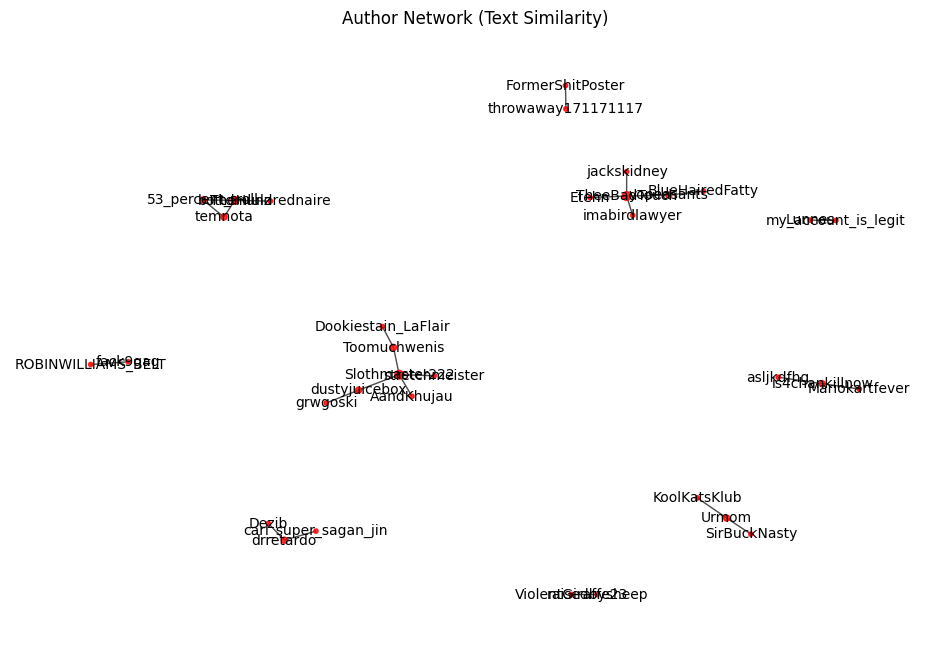

In [ ]:
def matplot_networkx_graph(G):
    # Set node sizes based on a centrality measure (e.g., degree centrality)
    node_size = [10 * G.degree[node] for node in G.nodes()]

    # Choose a layout algorithm (e.g., spring layout)
    pos = nx.spring_layout(G)

    # Create the visualization
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Draw nodes with different colors based on label (optional)
    node_color = ['red' if label == 1 else 'blue' for label in data['label']]

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color="red", node_size=node_size, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.7)

    # Add labels for nodes (optional)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Add a title and axis labels
    plt.title("Author Network (Text Similarity)")
    plt.axis('off')

    # Display the plot
    plt.show()

matplot_networkx_graph(G)

Ughhh, not so good. Too cluttered. We can use Plotly for an interactive graph visualization. It's a bit of work, but totally worth it.

In [ ]:
def plotly_networkx_graph(G):
    # Get the node positions
    pos = nx.spring_layout(G)

    # Create the node trace
    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hovertext=node_text, hoverinfo='text',
                            marker=dict(
                                showscale=True,
                                colorscale='Viridis',
                                reversescale=True,
                                color=[],
                                size=10,
                                colorbar=dict(
                                    thickness=15,
                                    title='Node Connections',
                                    xanchor='left',
                                    titleside='right'),
                                line_width=2))

    # Create the edge trace
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        edge_x.append(x1)
        edge_x.append(x2)
        edge_x.append(None)
        edge_y.append(y1)
        edge_y.append(y2)
        edge_y.append(None)

    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                            line=dict(width=0.5, color='#888'),
                            hoverinfo='none', mode='lines')

    # Create the layout
    layout = go.Layout(title='Author Network (Text Similarity)', titlefont_size=16, showlegend=False, hovermode='closest',
                       margin=dict(b=20, l=5, r=5, t=40),
                       xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    # Create the figure and plot
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()

plotly_networkx_graph(G)

A lot better now eh? If you hover the nodes towards the center, you will find that the many users have toxic names. Anything similar to the Reddit Username case study?

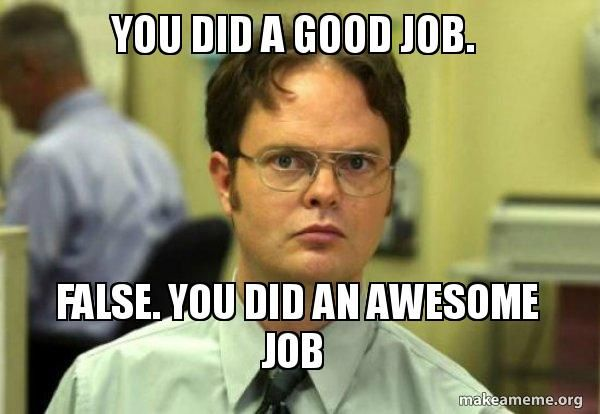